<a href="https://colab.research.google.com/github/KravitzLab/PsygeneAnalyses/blob/PCA_analysis/BEAM_spectral_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a notebook for Generating spectral data from BEAM for the Psygene project.  
<br>
<img src="https://github.com/KravitzLab/KreedLabWiki/blob/main/images/ChatGPT%20Image%20Apr%2020,%202025,%2004_05_24%20PM.png?raw=true" width="300" />

Updated: 04-18-25

Todo:
- normalize data per day
- think about metrics that we could drop?
- rename all_metrics to something task specific like beam_metrics

In [109]:
# @title Import libraries
import importlib.util
import subprocess
import sys
from scipy.signal import find_peaks
from pandas.api.types import is_numeric_dtype

packages = {
    "ipywidgets": "ipywidgets",
}

for name, source in packages.items():
    if importlib.util.find_spec(name) is None:
        print(f"Installing {name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", source])

import tempfile
import os
import zipfile
import io
import pandas as pd
from google.colab import files
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from statsmodels.formula.api import ols
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
from google.colab import output
output.enable_custom_widget_manager()
from scipy.optimize import curve_fit
from datetime import datetime
from collections import defaultdict
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')  # this is a bit dangerous but we'll supress all warnings

print("Packages installed.")


Packages installed.


In [ ]:
# @title Upload BEAM files


import os, io, zipfile, re
import pandas as pd
from google.colab import files


def upload_BEAM_files(append=False):
    """
    If append=False (default), this replaces global `dataframes` and `loaded_files`.
    If append=True, new files are appended to existing state.
    """
    uploaded = files.upload()
    if not uploaded:
        raise ValueError("No files uploaded.")

    # start fresh unless appending
    if not append:
        globals().pop("dataframes", None)
        globals().pop("loaded_files", None)

    dfs_existing  = globals().get("dataframes", [])
    names_existing = globals().get("loaded_files", [])

    dfs_new, names_new = [], []

    # continue file_id numbering if appending; otherwise start at 1
    def _next_start():
        try:
            ids = [int(str(getattr(df, "file_id", df.get("file_id", "file_000")))[5:]) for df in dfs_existing]
            return (max(ids) + 1) if ids else 1
        except Exception:
            return 1

    next_id = _next_start() if append else 1

    for name, content in uploaded.items():
        name_str = str(name)

        if name_str.lower().endswith(".zip"):
            with zipfile.ZipFile(io.BytesIO(content), "r") as z:
                for member in z.namelist():
                    # keep only CSV files
                    if member.endswith("/") or (not member.lower().endswith(".csv")):
                        continue
                    with z.open(member) as f:
                        df = pd.read_csv(f)
                    df["source_file"] = f"{os.path.basename(name_str)}::{member}"
                    df["file_id"] = f"file_{next_id:03d}"
                    dfs_new.append(df)
                    # record the INNER CSV basename (not the ZIP name)
                    names_new.append(os.path.basename(member))
                    next_id += 1

        elif name_str.lower().endswith(".csv"):
            df = pd.read_csv(io.BytesIO(content))
            df["source_file"] = os.path.basename(name_str)
            df["file_id"] = f"file_{next_id:03d}"
            dfs_new.append(df)
            names_new.append(os.path.basename(name_str))
            next_id += 1

        else:
            print(f"[i] Skipping non-CSV file: {name_str}")

    if not dfs_new:
        raise ValueError("No CSV files found. Upload .csv or a .zip containing CSVs.")

    # commit to globals
    dataframes   = (dfs_existing + dfs_new) if append else dfs_new
    loaded_files = (names_existing + names_new) if append else names_new
    globals()["dataframes"] = dataframes
    globals()["loaded_files"] = loaded_files

    print(f"Loaded {len(dfs_new)} CSV(s) from {len(uploaded)} upload(s). "
          f"Current session now has {len(dataframes)} CSV(s).")
    print("Example filenames used for metadata linking:", loaded_files[:5])
    return dataframes, loaded_files

# Use it:
dataframes, loaded_files = upload_BEAM_files(append=False)

print(type(dataframes))




In [ ]:
# @title # rip a meta key from files

meta = {}   # final output: {animal_id: {meta_key: meta_value}}



for df in dataframes:
    # select only object/string columns
    obj_cols = df.select_dtypes(include='object').columns.tolist()
    df['suffix'] = df['source_file'].str.extract(r'(_\d{3}_\d{1,}_\d{1,})')

    df["Gene"] = df['source_file'].str.extract(r'(^[A-Za-z0-9]+)')

    # Check if all values could be converted to numeric (i.e., no NaNs introduced)
    numeric_col = pd.to_numeric(df['Gene'], errors='coerce')
    is_entirely_numeric = numeric_col.notna().all()
    if is_entirely_numeric:
      #print(f"Gene column is all numeric: defaulting to Strain for Gene")
      df["Gene"] = df['Strain']

    # Create Mouse_ID
    df['Mouse_ID'] = df['Gene'] + df['suffix']

    # explicitly remove columns you want to skip (case-insensitive)
    skip_cols = {"datetime", "file_date", "source_file", "file_id",
                 "library_version", 'suffix'}
    obj_cols = [c for c in obj_cols if c.lower() not in skip_cols]

    # extract metadata
    info = {}
    for col in obj_cols:
        vals = df[col].dropna().unique()
        if len(vals) == 1:
            info[col] = vals[0]
        else:
            info[col] = vals.tolist()

    # find animal_id column (case-insensitive: 'animal_id' or 'mouse_id')
    animal_id_col = next((c for c in obj_cols if c.lower() in ["animal_id"]), None)
    if animal_id_col is None:
        raise ValueError(f"No animal ID column found in metadata. Available columns: {obj_cols}")

    animal_id = info[animal_id_col]
    if isinstance(animal_id, list):
        animal_id = animal_id[0]

    meta[animal_id] = info

key_df = pd.DataFrame.from_dict(meta, orient='index')


"""
# Replace empty lists with NaN
key_df['Mouse_ID'] = key_df['Mouse_ID'].apply(lambda x: np.nan if x == [] else x)

# If any entries are lists, take the first element
key_df['Mouse_ID'] = key_df['Mouse_ID'].apply(lambda x: x[0] if isinstance(x, list) else x)

filled = key_df[key_df['Mouse_ID'].notna()]

# Extract Strain and Prefix
strain_prefix = {}
for mid in filled['Mouse_ID']:
    parts = mid.split('_')
    gene = parts[0]
    prefix = parts[1]
    strain_prefix[gene] = prefix  # latest value per gene

mask = key_df['Mouse_ID'].isna()
key_df.loc[mask, 'Mouse_ID'] = key_df.loc[mask].apply(
    lambda row: f"{row['Strain']}_{strain_prefix[row['Strain']]}_{row['Animal_ID']}",
    axis=1
)


print(strain_prefix)
"""

print(key_df)


In [ ]:
# @title Average by animals

dfs = dataframes.copy()

# the column you want to group by
group_col = 'Animal_ID'
# common time interval for BEAMs
resample_freq = '10T'

grouped_results = {}

for df in dfs:
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Extract the group label (keep for later)
    group = df[group_col].iloc[0]

    # Set datetime index
    df = df.set_index('datetime').sort_index()

    # Select only numeric columns for averaging (keep group info separate)
    numeric_cols = df.select_dtypes(include='number').columns
    df_numeric = df[numeric_cols]

    # Resample and interpolate
    df_numeric = df_numeric.resample(resample_freq).mean().interpolate(limit_direction='both')

    # Add to grouped list
    grouped_results.setdefault(group, []).append(df_numeric)

# Now average within each group
group_averages = {}
for group, df_list in grouped_results.items():
    combined = pd.concat(df_list, axis=1)
    avg = combined.groupby(level=0, axis=1).mean()  # average numeric columns
    group_averages[group] = avg

# Check available groups
print("Groups available:", list(group_averages.keys()))

# Access a group’s averaged DataFrame
avg_df = group_averages[list(group_averages.keys())[0]]



# This is code for plotting all beam activity TS
"""
columns_to_plot = ['activity_count']

for group, avg_df in group_averages.items():
    n_cols = len(columns_to_plot)
    fig, axes = plt.subplots(n_cols, 1, figsize=(12, 3*n_cols), sharex=True)

    # Ensure axes is always a list/array
    if n_cols == 1:
        axes = [axes]

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        ax.plot(avg_df.index, avg_df[col], color='blue')
        ax.set_ylabel(col)
        ax.grid(True)
        ax.set_title(f'{group} - {col}', fontsize=10)
        ax.autoscale(enable=True)  # y-axis scales independently

    axes[-1].set_xlabel('Time')
    plt.suptitle(f'Averaged Time Series for Group: {group}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
"""

In [ ]:
# @title define functions for peak and valley analysis
# peak and valley information

def peak_valley_analysis(grouped_dict, column="activity_count",
                         peak_prominence=5, valley_prominence=5):
    """
    grouped_dict: dict of {group_name: DataFrame}, each with datetime index
    column: which column to analyze
    """
    results = {}

    for group, df in grouped_dict.items():

        # --- ensure sorted time index ---
        df = df.sort_index()

        y = df[column].values

        # --- Find peaks ---
        peak_idx, _ = find_peaks(y, prominence=peak_prominence)
        peak_times = df.index[peak_idx]
        peak_values = y[peak_idx]

        # --- Find valleys (invert signal) ---
        valley_idx, _ = find_peaks(-y, prominence=valley_prominence)
        valley_times = df.index[valley_idx]
        valley_values = y[valley_idx]

        results[group] = {
            "peaks": pd.DataFrame({"time": peak_times, "value": peak_values}),
            "valleys": pd.DataFrame({"time": valley_times, "value": valley_values}),
            "n_peaks": len(peak_idx),
            "n_valleys": len(valley_idx),
        }

    return results


results = peak_valley_analysis(group_averages, column="activity_count")


### Define function to plot peaks and valleys ###
def plot_group_peaks(group_name):
    df = group_averages[group_name]
    df = df.sort_index()

    res = results[group_name]

    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["activity_count"], label="Activity")

    plt.scatter(res["peaks"]["time"], res["peaks"]["value"], s=30, label="Peaks")
    plt.scatter(res["valleys"]["time"], res["valleys"]["value"], s=30, label="Valleys")

    plt.title(f"Peaks & Valleys - {group_name}")
    plt.legend()
    plt.show()


# return information
print(results["145_36"]["peaks"].head())
print(results["145_36"]["valleys"].head())
plot_group_peaks("145_36")





In [ ]:
# @title Compute metrics for Animals

def compute_metrics(results):
    metrics = {}

    for group, res in results.items():

        peaks = res["peaks"]
        valleys = res["valleys"]

        # --- Peak intervals ---
        if len(peaks) > 1:
            peak_intervals = np.diff(peaks["time"]).astype("timedelta64[m]").astype(int)
        else:
            peak_intervals = []

        # --- Valley intervals ---
        if len(valleys) > 1:
            valley_intervals = np.diff(valleys["time"]).astype("timedelta64[m]").astype(int)
        else:
            valley_intervals = []

        # --- Peak to Valley differences ---
        if len(peaks) > 0 and len(valleys) > 0:
            # align shortest list for pairwise difference
            n = min(len(peaks), len(valleys))
            pv_diff = peaks["value"].iloc[:n] - valleys["value"].iloc[:n]
        else:
            pv_diff = []

        metrics[group] = {
            # Counts
            "n_peaks": res["n_peaks"],
            "n_valleys": res["n_valleys"],

            # Peak metrics
            "peak_mean_height": peaks["value"].mean() if len(peaks) else np.nan,
            "peak_max_height": peaks["value"].max() if len(peaks) else np.nan,
            "peak_variability": peaks["value"].std() if len(peaks) else np.nan,
            "peak_mean_interval_minutes": np.mean(peak_intervals) if len(peak_intervals) else np.nan,
            "peak_irregularity_index": np.std(peak_intervals) / np.mean(peak_intervals)
                                      if len(peak_intervals) > 1 else np.nan,

            # Valley metrics
            "valley_mean_depth": valleys["value"].mean() if len(valleys) else np.nan,
            "valley_min_depth": valleys["value"].min() if len(valleys) else np.nan,
            "valley_mean_interval_minutes": np.mean(valley_intervals) if len(valley_intervals) else np.nan,

            # Amplitude metrics
            "mean_peak_to_valley_difference": pv_diff.mean() if len(pv_diff) else np.nan,
            "max_peak_to_valley_difference": pv_diff.max() if len(pv_diff) else np.nan,
        }

    return pd.DataFrame(metrics).T

metrics_df = compute_metrics(results)
metrics_df


In [ ]:
# @title Define function for night/day metrics analysis

def day_night_metrics(group_averages, peakval_results,
                      light_start = 6, dark_start = 18,
                      activity_col="activity_count"):
    out = {}

    for animal, df in group_averages.items():
        df = df.copy()

        # Ensure datetime index
        df.index = pd.to_datetime(df.index)

        # Separate day/night (default day = 06:00–18:00)
        day_mask = (df.index.hour >= light_start) & (df.index.hour < dark_start)
        night_mask = ~day_mask

        day_vals = df.loc[day_mask, activity_col]
        night_vals = df.loc[night_mask, activity_col]


        # ----- Peak/Valley summaries -----
        peaks = peakval_results[animal]["peaks"].copy()
        valleys = peakval_results[animal]["valleys"].copy()

        # day/night peaks
        peaks["time"] = pd.to_datetime(peaks["time"])
        valleys["time"] = pd.to_datetime(valleys["time"])

        day_peaks = peaks[peaks["time"].dt.hour.between(6, 17)]
        night_peaks = peaks[~peaks["time"].dt.hour.between(6, 17)]

        day_valleys = valleys[valleys["time"].dt.hour.between(6, 17)]
        night_valleys = valleys[~valleys["time"].dt.hour.between(6, 17)]





        # --- Day & Night Peak intervals ---
        # Day
        if len(day_peaks) > 1:
            day_peak_intervals = np.diff(peaks["time"]).astype("timedelta64[m]").astype(int)
        else:
            day_peak_intervals = []

        # Night
        if len(night_peaks) > 1:
            night_peak_intervals = np.diff(peaks["time"]).astype("timedelta64[m]").astype(int)
        else:
            night_peak_intervals = []



        # --- Day & Night Valley intervals ---
        if len(day_valleys) > 1:
            day_valley_intervals = np.diff(valleys["time"]).astype("timedelta64[m]").astype(int)
        else:
            day_valley_intervals = []

        if len(night_valleys) > 1:
            night_valley_intervals = np.diff(valleys["time"]).astype("timedelta64[m]").astype(int)
        else:
            night_valley_intervals = []



        # ----- Metrics -----
        out[animal] = {
            # Activity
            "day_mean_activity": day_vals.mean(),
            "night_mean_activity": night_vals.mean(),
            "day_night_ratio": (
                day_vals.mean() / night_vals.mean()
                if night_vals.mean() != 0 else np.nan
            ),

            "day_peak_variability": day_peaks["value"].std() if len(day_peaks["value"]) else np.nan,
            "night_peak_variability": night_peaks["value"].std() if len(night_peaks["value"]) else np.nan,
            "day_peak_mean_interval_minutes": np.mean(day_peak_intervals) if len(day_peak_intervals) else np.nan,
            "night_peak_mean_interval_minutes": np.mean(night_peak_intervals) if len(night_peak_intervals) else np.nan,
            "day_peak_irregularity_index": np.std(day_peak_intervals) / np.mean(day_peak_intervals)
                                           if len(day_peak_intervals) > 1 else np.nan,
            "night_peak_irregularity_index": np.std(night_peak_intervals) / np.mean(night_peak_intervals)
                                             if len(night_peak_intervals) > 1 else np.nan,
            "day_valley_mean_interval_minutes": np.mean(day_valley_intervals) if len(day_valley_intervals) else np.nan,
            "night_valley_mean_interval_minutes": np.mean(day_valley_intervals) if len(day_valley_intervals) else np.nan,

            # Peak metrics
            "num_day_peaks": len(day_peaks),
            "num_night_peaks": len(night_peaks),
            "max_peak_value": peaks["value"].max(),
            "time_of_max_peak": peaks.loc[peaks["value"].idxmax(), "time"],

            # Valley metrics
            "num_day_valleys": len(day_valleys),
            "num_night_valleys": len(night_valleys),
            "min_valley_value": valleys["value"].min(),
            "time_of_min_valley": valleys.loc[valleys["value"].idxmin(), "time"],
        }

    return pd.DataFrame(out).T




daynight_df = day_night_metrics(group_averages, results)
daynight_df


In [ ]:
# @title Merge Everything

combined = (
    key_df
    .join(daynight_df, how="outer")
    .join(metrics_df, how="outer")
)

# set column names to lowercase
combined.columns = combined.columns.str.lower()
combined["genotype"] = combined["genotype"].str.upper()

cols_to_drop = ['min_valley_value', 'valley_min_depth']
combined = combined.drop(columns=cols_to_drop)

combined = combined.infer_objects()




# ---------- Save CSV ----------
csv_name = f"combined_beam_spectral.csv"

# prepare df to match format of other files
down_df = combined.copy()


# Define a dictionary for renaming
rename_mapping = {'mouse_id': 'Mouse_ID',
                  'sex': 'Sex$',
                  'genotype': 'Genotype$',
                  'gene': 'Gene',}

# Rename the columns
down_df.rename(columns=rename_mapping, inplace=True)
down_df['session_type'] = 'beam'
down_df['Mouse_ID'] = down_df['Mouse_ID'].str.upper()
down_df.drop('animal_id', axis=1, inplace=True)
down_df.drop('strain', axis=1, inplace=True)

print(down_df)

down_df = down_df.to_csv(csv_name, index=False)

try:
    from google.colab import files as gfiles
except Exception:
    gfiles = None

# Optional download button (works in Colab)
btn = widgets.Button(description=f"Download {os.path.basename(csv_name)}", icon="download")
status = widgets.HTML()
def _dl(_):
    if gfiles is not None:
        status.value = f"Starting download: <code>{os.path.basename(csv_name)}</code>…"
        gfiles.download(csv_name)
    else:
        status.value = f"Saved locally at <code>{csv_name}</code>."
display(btn, status)
btn.on_click(_dl)

"""
write = False
if write == True:
  # Prepare and format
  output_file = "combined_beam.csv"
  combined.to_csv(output_file, index=False)
  files.download(output_file)
"""

['day_mean_activity', 'night_mean_activity', 'day_night_ratio', 'day_peak_variability', 'night_peak_variability', 'day_peak_mean_interval_minutes', 'night_peak_mean_interval_minutes', 'day_peak_irregularity_index', 'night_peak_irregularity_index', 'day_valley_mean_interval_minutes', 'night_valley_mean_interval_minutes', 'num_day_peaks', 'num_night_peaks', 'max_peak_value', 'num_day_valleys', 'num_night_valleys', 'min_valley_value', 'n_peaks', 'n_valleys', 'peak_mean_height', 'peak_max_height', 'peak_variability', 'peak_mean_interval_minutes', 'peak_irregularity_index', 'valley_mean_depth', 'valley_min_depth', 'valley_mean_interval_minutes', 'mean_peak_to_valley_difference', 'max_peak_to_valley_difference']


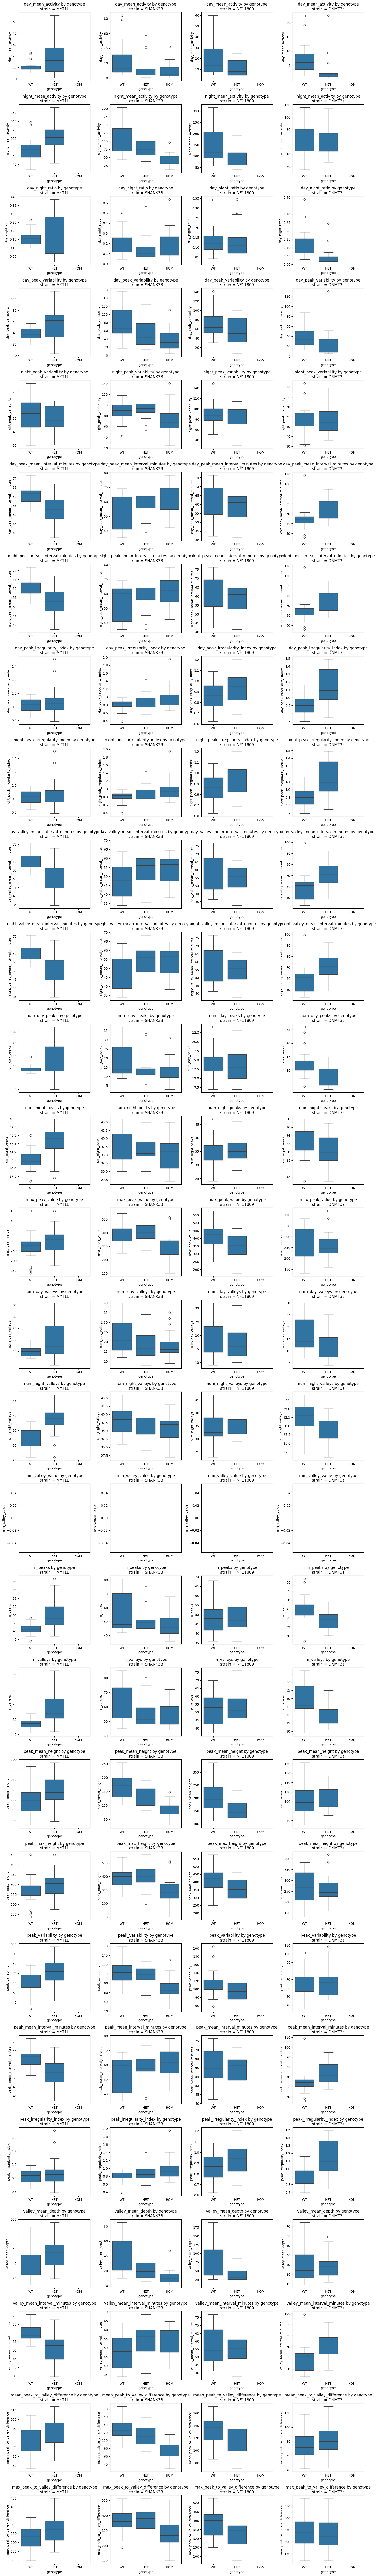

In [195]:
# @title # Visualize boxplots for all metrics

import matplotlib.pyplot as plt
import seaborn as sns


# Columns
numeric_cols = combined.select_dtypes(include='number').columns.tolist()
print(numeric_cols)
numeric_cols.remove("valley_min_depth")
group_by_col = "genotype"  # categorical variable to compare
facet_col = "strain"       # another categorical

# Order
genotype_order = ["WT", "HET", "HOM"]

strains = combined[facet_col].unique()
n_strains = len(strains)
n_numeric = len(numeric_cols)

# Create subplots: rows = numeric_cols, cols = strains
fig, axes = plt.subplots(n_numeric, n_strains,
                         figsize=(4*n_strains, 4*n_numeric), squeeze=False)

for i, num_col in enumerate(numeric_cols):
    for j, strn in enumerate(strains):
        ax = axes[i, j]
        sns.boxplot(
            data = combined[combined[facet_col] == strn],
            x = group_by_col,
            y = num_col,
            ax=ax,
            order=genotype_order
        )
        ax.set_title(f"{num_col} by {group_by_col}\n{facet_col} = {strn}")
        ax.set_xlabel(group_by_col)
        ax.set_ylabel(num_col)

plt.tight_layout()
plt.show()


In [ ]:
# @title # Conduct PCA analysis for metrics based on spectral

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------
# Step 1: Prepare PCA data
# -------------------------

key_cols = key_df.columns.str.lower()  # Columns to drop
pca_df = combined.drop(columns=key_cols)

# Drop object, bool, datetime columns
drops = pca_df.select_dtypes(include=['object', 'bool', 'datetime64']).columns
pca_df = pca_df.drop(columns=drops)

# Ensure index matches combined
pca_df.index = combined.index

# Select numeric features
features = pca_df.select_dtypes(include=['int64', 'float64']).columns
x = StandardScaler().fit_transform(pca_df[features])

# PCA transformation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x)

# Create PCA DataFrame with aligned index
clustering_df_pca = pd.DataFrame(
    data=pca_result,
    columns=['principal component 1', 'principal component 2'],
    index=pca_df.index
)

print("Explained variance per component:", pca.explained_variance_ratio_)

# -------------------------
# Step 2: Plot PCA
# -------------------------

categorical_columns = ['strain', 'genotype']

for cat_col in categorical_columns:
    plt.figure(figsize=(6,6))
    plt.title(f"PCA colored by {cat_col}", fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)

    # Drop NaNs for plotting
    targets = combined[cat_col].dropna().unique()
    cmap = plt.cm.get_cmap('viridis', len(targets))
    colors = [cmap(i) for i in range(len(targets))]

    for i, target in enumerate(targets):
        # Boolean mask aligned with PCA DataFrame
        mask = (combined[cat_col] == target).reindex(clustering_df_pca.index, fill_value=False)

        if mask.sum() == 0:
            print(f"Warning: No rows found for {cat_col}={target}")
            continue

        plt.scatter(
            clustering_df_pca.loc[mask, 'principal component 1'],
            clustering_df_pca.loc[mask, 'principal component 2'],
            color=colors[i],
            s=50,
            alpha=0.7,
            edgecolors='k',
            label=str(target)
        )

    plt.legend(title=cat_col, fontsize=9, title_fontsize=11)
    plt.tight_layout()
    plt.show()

